In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M53_01_02.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_04.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_04_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_01_09.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_03_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_02_10.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_06.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_01_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_10.jpg
/kaggle/input/monkeypox-s

In [39]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
import torchvision.models as models

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns

import time
from collections import OrderedDict

import platform
import psutil

import random
import glob
from tqdm import tqdm

from PIL import Image
from torchvision import transforms
from PIL import ImageOps

from tabulate import tabulate

In [40]:
import os
import pandas as pd

data_dir = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):  # Only proceed if it's a directory
        for root, _, files in os.walk(class_dir):
            for image_name in files:
                file_path = os.path.join(root, image_name)
                if os.path.isfile(file_path):  # Skip directories
                    file_paths.append(file_path)
                    labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)


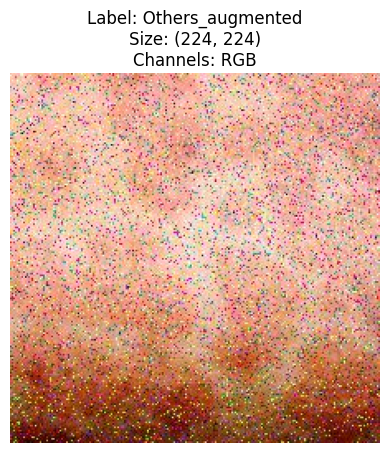

In [41]:
import random
from PIL import Image
import matplotlib.pyplot as plt

random_index = random.randint(0, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)

size = image.size
channels = 'Grayscale' if image.mode == 'L' else 'RGB'

plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
plt.imshow(image, cmap='gray' if image.mode == 'L' else None)
plt.axis('off')
plt.show()


Class: Others_augmented, Count: 1764
Class: Monkeypox_augmented, Count: 1428


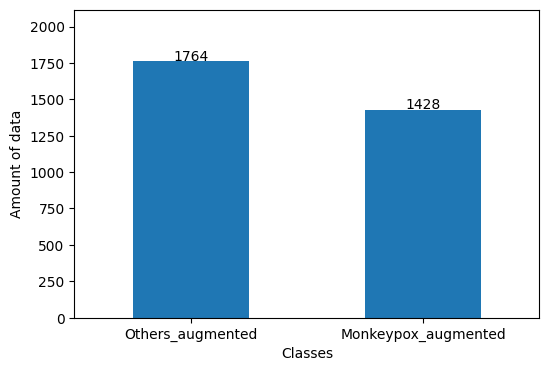

In [42]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

In [44]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
test_dataframe, valid_dataframe = train_test_split(temp_dataframe, test_size=0.5, stratify=temp_dataframe['label'], random_state=42)

In [45]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  2553
Validation Data:  320
Test Data:  319
-------------------------------------------
Total amounts of data in the dataset:  3192


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
print(f"Device : {device}")

Device : cpu


In [48]:
save_path_checkpoints = "/content/drive/MyDrive/Colab Notebooks/CNN"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [50]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'monkeypox': 0, 'others': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [51]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Define your custom dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Monkeypox': 0, 'Others': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = Image.open(img_path).convert('RGB')

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

# Set batch size
batch = 8

# Step 1: Create DataFrame with image paths and labels
def create_dataframe(base_path):
    data = []
    for label_name in ['Monkeypox_augmented', 'Others_augmented']:
        folder = os.path.join(base_path, label_name)
        label = 'Monkeypox' if 'Monkeypox' in label_name else 'Others'
        for file_name in os.listdir(folder):
            if file_name.lower().endswith('.jpg'):
                file_path = os.path.join(folder, file_name)
                data.append({'file_path': file_path, 'label': label})
    return pd.DataFrame(data)

# Define transform function
def data_transform():
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Create the main dataframe
    base_dir = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
    full_df = create_dataframe(base_dir)

    # Split dataset into train/valid/test (e.g., 70/15/15 split)
    train_df, temp_df = train_test_split(full_df, test_size=0.3, stratify=full_df['label'], random_state=42)
    valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

    # Create datasets
    train_dataset = ImageDataset(train_df, normalize, is_lb=True)
    valid_dataset = ImageDataset(valid_df, normalize, is_lb=True)
    test_dataset  = ImageDataset(test_df, normalize, is_lb=True)

    # Create dataloaders
    dataloader_train_dataset = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size=batch, shuffle=False, num_workers=2)
    dataloader_test_dataset  = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

# Run it
dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transform()


### Design and Implementation of CNN model

In [52]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)  # 3 output classes

        # Dropout layer (to prevent overfitting)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convolutional block
        x = self.pool(F.relu(self.conv1(x)))

        # Second convolutional block
        x = self.pool(F.relu(self.conv2(x)))

        # Third convolutional block
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 28 * 28)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [53]:
model = CNN_model()
model = model.to(device)

In [54]:
print(model.parameters)

<bound method Module.parameters of CNN_model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>


In [55]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

### Model Training

In [56]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=10, early_stop_patience=3, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

Epoch 1/10: 100%|██████████| 280/280 [04:43<00:00,  1.01s/it, acc=0.585, loss=0.702]

Training Loss: 0.702 Acc: 0.585


Validation Loss: 0.640 Acc: 0.653
Best model saved at epoch 1 with validation accuracy: 0.653


Epoch 2/10: 100%|██████████| 280/280 [04:42<00:00,  1.01s/it, acc=0.654, loss=0.646]

Training Loss: 0.646 Acc: 0.654


Validation Loss: 0.691 Acc: 0.608


Epoch 3/10: 100%|██████████| 280/280 [05:24<00:00,  1.16s/it, acc=0.684, loss=0.615]

Training Loss: 0.615 Acc: 0.684


Validation Loss: 0.620 Acc: 0.676
Best model saved at epoch 3 with validation accuracy: 0.676


Epoch 4/10: 100%|██████████| 280/280 [05:33<00:00,  1.19s/it, acc=0.703, loss=0.597]

Training Loss: 0.597 Acc: 0.703


Validation Loss: 0.589 Acc: 0.710
Best model saved at epoch 4 with validation accuracy: 0.710


Epoch 5/10: 100%|██████████| 280/280 [06:03<00:00,  1.30s/it, acc=0.725, loss=0.574]

Training Loss: 0.574 Acc: 0.725


Validation Loss: 0.571 Acc: 0.720
Best model saved at epoch 5 with validation accuracy: 0.720


Epoch 6/10: 100%|██████████| 280/280 [06:11<00:00,  1.33s/it, acc=0.754, loss=0.518]

Training Loss: 0.518 Acc: 0.754


Validation Loss: 0.524 Acc: 0.745
Best model saved at epoch 6 with validation accuracy: 0.745


Epoch 7/10: 100%|██████████| 280/280 [05:44<00:00,  1.23s/it, acc=0.784, loss=0.471]

Training Loss: 0.471 Acc: 0.784


Validation Loss: 0.480 Acc: 0.777
Best model saved at epoch 7 with validation accuracy: 0.777


Epoch 8/10: 100%|██████████| 280/280 [06:10<00:00,  1.32s/it, acc=0.795, loss=0.437]

Training Loss: 0.437 Acc: 0.795


Validation Loss: 0.459 Acc: 0.787
Best model saved at epoch 8 with validation accuracy: 0.787
Early stopping criteria met. No improvement in validation accuracy or validation loss for 3 consecutive epochs. Training stopped.


In [57]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [58]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 8) - Validation Loss: 0.459, Validation Accuracy: 0.787


In [59]:
test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Accuracy: 0.816


In [60]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(3)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, 3)
class_names = {0: "angry", 1: "happy", 2: "sad"}
total_class = len(class_names)
for i in range(total_class):
    print(f"{class_names[i]} Accuracy: {class_acc[i]:.3f}")

Classification Report:


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter